# Traning Dataset To Detect Orchid Feathure

## Setup

In [14]:
!nvidia-smi

Sat Nov 30 04:09:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [16]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [17]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xt1xKtAXVG6mSVmmocMF")
project = rf.workspace("mproject-q94fe").project("orchid1-twcxw")
version = project.version(7)
dataset = version.download("yolov11")



loading Roboflow workspace...
loading Roboflow project...


## Download Dataset to Local Machine

In [9]:
# !zip -r /content/orchid1-7.zip /content/orchid1-7


  adding: content/orchid1-7/ (stored 0%)
  adding: content/orchid1-7/README.dataset.txt (deflated 12%)
  adding: content/orchid1-7/README.roboflow.txt (deflated 47%)
  adding: content/orchid1-7/data.yaml (deflated 37%)
  adding: content/orchid1-7/valid/ (stored 0%)
  adding: content/orchid1-7/valid/images/ (stored 0%)
  adding: content/orchid1-7/valid/images/IMG-20241123-WA0358_jpg.rf.6b6682af380f5578d1b5ff340fba3861.jpg (deflated 0%)
  adding: content/orchid1-7/valid/images/427_jpg.rf.f7badafda05df548d057140199f2335b.jpg (deflated 0%)
  adding: content/orchid1-7/valid/images/IMG-20241123-WA0109_jpg.rf.4053a7b2fd934b8335db92749ef27a1b.jpg (deflated 0%)
  adding: content/orchid1-7/valid/images/IMG-20241123-WA0036_jpg.rf.93c509a07c24135bf68a8f7d120b83a1.jpg (deflated 1%)
  adding: content/orchid1-7/valid/images/IMG-20241123-WA0051_jpg.rf.71d8ba13884ef4f92775b8b31616bbeb.jpg (deflated 0%)
  adding: content/orchid1-7/valid/images/432_jpg.rf.d03f195d2b737fb86fb4a9ebce98a620.jpg (deflated 0%

In [10]:
# from google.colab import files
# files.download('/content/orchid1-7.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prepare Dataset Paths

In [18]:
dataset_path = dataset.location
print(f"Dataset downloaded to: {dataset_path}")

# Verify the content
!ls {dataset_path}


Dataset downloaded to: /content/orchid1-7
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


# Train YOLOv11

In [38]:
from ultralytics import YOLO

# Load your segmentation model
orchid_model = YOLO('yolo11l-seg.pt')
orchid_model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, tra

### Before Train model out put


0: 640x640 2 potted plants, 1 vase, 66.8ms
Speed: 3.8ms preprocess, 66.8ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)


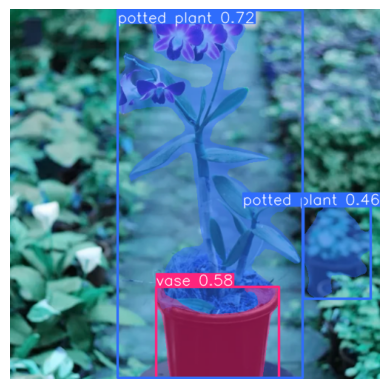

In [39]:
from ultralytics import YOLO
from PIL import Image
import requests
import matplotlib.pyplot as plt

# Load an image
image_url = "https://5.imimg.com/data5/SELLER/Default/2024/6/426884907/CX/RS/IW/46470149/dendrobium-orchid-flower-plant-500x500.png"
image = Image.open(requests.get(image_url, stream=True).raw)

# Perform segmentation
results = orchid_model.predict(image, task='segment', imgsz=640)  # Predict masks

# Extract the first result (if working with a single image)
result = results[0]

# Display the image with segmentation results
annotated_image = result.plot()  # `plot()` overlays the masks, bounding boxes, and labels onto the image

# Use matplotlib to show the annotated image
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

### Traning Model with custorm dataset

In [20]:
# Train the model for segmentation
orchid_model.train(
    data=os.path.join(dataset_path, 'data.yaml'),  # Path to dataset's YAML file
    epochs=50,                         # Number of training epochs
    imgsz=640,                         # Image size (adjust based on your dataset)
    batch=16,                          # Batch size
    task='segment'                     # Specify segmentation task
)


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=/content/orchid1-7/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 42.2MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 182MB/s]


AMP: checks passed ✅


train: Scanning /content/orchid1-7/train/labels... 671 images, 0 backgrounds, 0 corrupt: 100%|██████████| 671/671 [00:01<00:00, 500.00it/s]


train: New cache created: /content/orchid1-7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/orchid1-7/valid/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 314.85it/s]

val: New cache created: /content/orchid1-7/valid/labels.cache


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.2G      1.479      3.272      2.305      1.662        341        640: 100%|██████████| 42/42 [01:03<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         45        619      0.227      0.451      0.274      0.147      0.212      0.197      0.152     0.0658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.1G      1.389      2.759      1.493      1.561        403        640: 100%|██████████| 42/42 [00:52<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         45        619      0.206      0.281     0.0891      0.049       0.12      0.145     0.0573     0.0225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.1G       1.43      2.847      1.512      1.594        317        640: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         45        619      0.334      0.394      0.309      0.156      0.209       0.21      0.158     0.0658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.3G      1.427      2.783      1.458      1.589        457        640: 100%|██████████| 42/42 [00:51<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         45        619      0.211      0.355      0.204     0.0986      0.244      0.226      0.165     0.0693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.2G      1.376      2.683       1.42      1.555        400        640: 100%|██████████| 42/42 [00:51<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         45        619      0.386      0.405      0.394      0.203      0.296      0.294      0.242     0.0925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      13.2G      1.349      2.626      1.346       1.54        359        640: 100%|██████████| 42/42 [00:52<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         45        619      0.427      0.446      0.416      0.227      0.335      0.372      0.331      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.2G      1.332      2.617      1.322      1.539        266        640: 100%|██████████| 42/42 [00:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         45        619      0.434      0.447       0.43      0.234      0.419      0.404      0.367      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.4G      1.291      2.499      1.248      1.511        272        640: 100%|██████████| 42/42 [00:51<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         45        619      0.452      0.516      0.456      0.251      0.407      0.453      0.407      0.171



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.3G      1.287      2.498      1.222      1.495        314        640: 100%|██████████| 42/42 [00:50<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all         45        619       0.48      0.491      0.447      0.256      0.412      0.422      0.361      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.5G      1.252       2.39      1.211      1.478        258        640: 100%|██████████| 42/42 [00:50<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         45        619      0.506      0.489      0.455      0.256      0.462      0.442      0.394       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.1G      1.232      2.374      1.183      1.451        428        640: 100%|██████████| 42/42 [00:52<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all         45        619      0.561      0.495      0.493      0.271      0.502       0.43      0.396      0.181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.9G      1.206      2.309      1.155      1.434        400        640: 100%|██████████| 42/42 [00:50<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all         45        619      0.593      0.504      0.494      0.289      0.526      0.437      0.413      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      12.9G      1.203      2.279      1.125      1.435        268        640: 100%|██████████| 42/42 [00:50<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         45        619      0.553      0.526      0.516      0.294      0.505      0.477      0.447      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50        13G      1.176      2.251      1.097      1.415        462        640: 100%|██████████| 42/42 [00:51<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         45        619      0.539      0.502      0.513      0.303      0.531      0.468      0.465      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.2G      1.161      2.238      1.085      1.421        392        640: 100%|██████████| 42/42 [00:50<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         45        619      0.585      0.558      0.543      0.317      0.545       0.52      0.492      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      13.3G      1.149      2.195      1.058      1.394        412        640: 100%|██████████| 42/42 [00:50<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         45        619      0.565      0.575      0.567      0.337      0.542      0.531      0.517      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      13.1G       1.11      2.108     0.9982      1.364        431        640: 100%|██████████| 42/42 [00:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         45        619        0.6      0.528      0.549      0.318      0.536      0.542      0.515      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      13.3G      1.128      2.119      1.016      1.383        327        640: 100%|██████████| 42/42 [00:50<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         45        619      0.594      0.523      0.531      0.313       0.56      0.496        0.5      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      13.3G      1.131      2.093      1.012       1.38        320        640: 100%|██████████| 42/42 [00:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

                   all         45        619      0.625      0.497      0.527      0.313      0.582      0.467       0.49      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      13.3G       1.11      2.072      1.008      1.378        356        640: 100%|██████████| 42/42 [00:49<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         45        619      0.652      0.534      0.557      0.333      0.612      0.503      0.506      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      13.1G      1.099      2.018     0.9611      1.357        349        640: 100%|██████████| 42/42 [00:49<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         45        619      0.521      0.533      0.534      0.317      0.499      0.472      0.471      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.1G       1.07      1.968     0.9181      1.344        389        640: 100%|██████████| 42/42 [00:53<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         45        619      0.596       0.53      0.533       0.31      0.595      0.483      0.503      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50        13G      1.041      1.945     0.8986      1.321        340        640: 100%|██████████| 42/42 [00:49<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         45        619      0.561      0.546       0.55       0.33        0.5       0.52      0.502      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      13.3G      1.022      1.921     0.8697      1.307        315        640: 100%|██████████| 42/42 [00:50<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         45        619      0.597      0.532      0.542      0.321      0.551      0.494      0.485      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      13.1G      1.026      1.887     0.8667      1.312        319        640: 100%|██████████| 42/42 [00:51<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         45        619        0.6      0.519      0.534      0.319      0.587      0.493      0.485      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      13.2G     0.9899      1.848     0.8261      1.283        318        640: 100%|██████████| 42/42 [00:49<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         45        619      0.609      0.535      0.561      0.341      0.584      0.513      0.516      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.1G      1.008      1.855      0.829      1.296        306        640: 100%|██████████| 42/42 [00:50<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         45        619      0.672      0.559      0.576       0.35      0.622      0.521      0.526      0.258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.4G     0.9934      1.856     0.8353      1.282        308        640: 100%|██████████| 42/42 [00:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         45        619      0.573      0.531      0.537       0.32      0.544      0.504      0.483      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.3G     0.9599      1.741     0.7876      1.266        377        640: 100%|██████████| 42/42 [00:49<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         45        619      0.673      0.563      0.591      0.355       0.61      0.523       0.53      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      13.5G     0.9673      1.753       0.79      1.265        426        640: 100%|██████████| 42/42 [00:49<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         45        619      0.637      0.522      0.561      0.336      0.601      0.494      0.509      0.258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50        13G     0.9311      1.709     0.7512      1.248        307        640: 100%|██████████| 42/42 [00:50<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         45        619      0.728      0.563      0.587       0.35      0.658      0.523       0.52      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      13.2G     0.9313      1.712     0.7463      1.238        343        640: 100%|██████████| 42/42 [00:50<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         45        619      0.569      0.567      0.567      0.341       0.53      0.554      0.514      0.254



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50        13G     0.9134      1.731     0.7355       1.23        447        640: 100%|██████████| 42/42 [00:49<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         45        619      0.569      0.593      0.582      0.355       0.51      0.546       0.51      0.266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      13.3G     0.9032       1.66     0.7044      1.216        389        640: 100%|██████████| 42/42 [00:52<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         45        619      0.606       0.57      0.568      0.347      0.634      0.491      0.505      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      13.1G     0.8892      1.622      0.701      1.211        293        640: 100%|██████████| 42/42 [00:49<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         45        619      0.585      0.579      0.573      0.344      0.623      0.467      0.505      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.3G      0.888      1.592      0.696      1.215        241        640: 100%|██████████| 42/42 [00:49<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         45        619      0.616      0.547      0.554      0.336      0.587      0.512       0.51       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      13.1G     0.8666      1.589     0.6745      1.194        425        640: 100%|██████████| 42/42 [00:50<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         45        619      0.666      0.527      0.575       0.36      0.639      0.506      0.536      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50        13G     0.8558      1.592      0.665      1.192        324        640: 100%|██████████| 42/42 [00:51<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         45        619      0.652      0.521      0.587      0.364      0.631      0.495       0.54      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.2G     0.8424      1.546       0.65      1.174        381        640: 100%|██████████| 42/42 [00:53<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         45        619      0.615      0.527      0.563       0.35       0.63      0.511      0.526       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      13.2G     0.8372       1.52     0.6397      1.175        357        640: 100%|██████████| 42/42 [00:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         45        619       0.66      0.529      0.585      0.354      0.627      0.498      0.539      0.267


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.8G     0.7527      1.292      0.529      1.146        311        640: 100%|██████████| 42/42 [00:46<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         45        619      0.622      0.544      0.582      0.355      0.591      0.519      0.532      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      12.8G     0.7191      1.238     0.4773      1.116        204        640: 100%|██████████| 42/42 [00:42<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         45        619      0.663      0.536      0.578      0.358      0.621      0.505      0.526      0.283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.9G     0.6968      1.194     0.4547      1.098        198        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         45        619      0.683      0.524      0.593      0.376      0.636      0.494      0.535      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.6G     0.6831      1.166     0.4451      1.082        187        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         45        619      0.664      0.542      0.587      0.364      0.603      0.493      0.526      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.9G     0.6703      1.157     0.4356      1.077        185        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         45        619      0.652      0.534      0.581      0.358      0.602      0.503      0.513      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      12.9G     0.6489      1.115     0.4133      1.067        221        640: 100%|██████████| 42/42 [00:44<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         45        619      0.663      0.546       0.59      0.359      0.625      0.506       0.53       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.9G     0.6504      1.111       0.41      1.064        160        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         45        619      0.666      0.539      0.584      0.369      0.639      0.523      0.542      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      12.9G     0.6285      1.084     0.3901      1.051        241        640: 100%|██████████| 42/42 [00:42<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         45        619      0.655      0.534      0.576       0.36      0.636      0.508      0.529      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      12.9G     0.6252      1.081     0.3949      1.045        176        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         45        619      0.667      0.532      0.577      0.357      0.604      0.491       0.52      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.9G      0.605      1.055     0.3829      1.034        214        640: 100%|██████████| 42/42 [00:42<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         45        619      0.677      0.516      0.577      0.357      0.612      0.491      0.525      0.285



50 epochs completed in 0.754 hours.
Optimizer stripped from runs/segment/train2/weights/last.pt, 55.8MB
Optimizer stripped from runs/segment/train2/weights/best.pt, 55.8MB

Validating runs/segment/train2/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11l-seg summary (fused): 491 layers, 27,589,989 parameters, 0 gradients, 141.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


                   all         45        619      0.683      0.524      0.594      0.376      0.638      0.496      0.539      0.292
                flower         21         89      0.792      0.729      0.762        0.5      0.805      0.741      0.775      0.492
                  leaf         45        310       0.79        0.7      0.811      0.573      0.797      0.706      0.792      0.508
                 plant         33         34      0.806      0.735      0.893       0.56      0.741      0.676      0.746      0.321
                   pot         34         38      0.851      0.579      0.687      0.438      0.773      0.526      0.627      0.322
                  root         19        105      0.458      0.238      0.231      0.104      0.311      0.162     0.0964     0.0346
                  stem         12         43      0.398      0.163      0.178     0.0778      0.398      0.163      0.197     0.0717
Speed: 0.2ms preprocess, 20.5ms inference, 0.0ms loss, 2.3ms postproc

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba8ecc60ac0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004

In [25]:
import os

os.makedirs('/content/output', exist_ok=True)


In [26]:
import shutil

# Path to the exported model
exported_model_path = 'runs/segment/train2/weights/best.pt'

# Specify the destination for saving the model
output_model_path = '/content/output/orchid_yolo_model.pt'

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_model_path), exist_ok=True)

# Move the exported model to the desired location
shutil.move(exported_model_path, output_model_path)

print(f"Model saved to: {output_model_path}")


Model saved to: /content/output/orchid_yolo_model.pt


## Model Validation

In [27]:
metrics = orchid_model.val(task='segment')  # Validate on segmentation task
print(metrics)


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11l-seg summary (fused): 491 layers, 27,589,989 parameters, 0 gradients, 141.9 GFLOPs


val: Scanning /content/orchid1-7/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


                   all         45        619       0.68      0.524      0.593      0.375      0.635      0.496      0.538      0.292
                flower         21         89      0.792      0.729      0.763      0.502      0.805      0.741      0.775      0.493
                  leaf         45        310       0.79        0.7      0.811      0.572      0.797      0.706       0.79      0.507
                 plant         33         34      0.806      0.735      0.893      0.559      0.742      0.676      0.746      0.322
                   pot         34         38      0.852      0.579      0.687      0.437      0.774      0.526      0.627      0.322
                  root         19        105      0.459      0.238      0.232      0.105      0.312      0.162     0.0964     0.0361
                  stem         12         43      0.379      0.163      0.174     0.0766      0.379      0.163      0.193     0.0701
Speed: 0.6ms preprocess, 58.4ms inference, 0.0ms loss, 6.5ms postproc

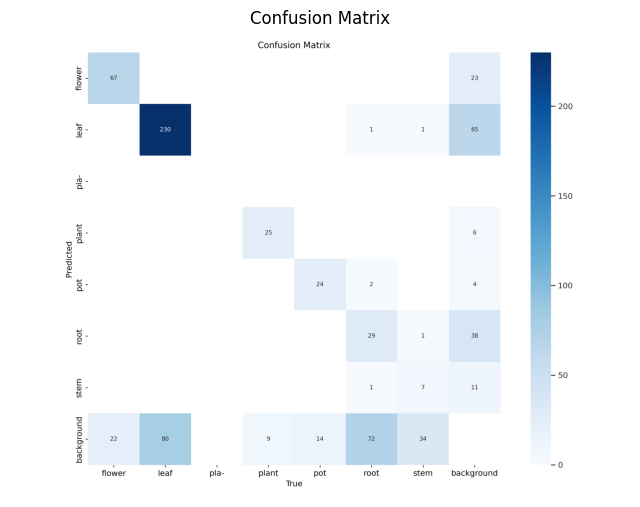

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the confusion matrix image
confusion_matrix_path = 'runs/segment/train2/confusion_matrix.png'

# Load and display the image
img = mpimg.imread(confusion_matrix_path)
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Confusion Matrix")
plt.show()


### Test with model test data

In [37]:
results = orchid_model.val(
    data=os.path.join(dataset_path, 'data.yaml'),  # Path to dataset's YAML file
    split='test',                                  # Use 'test' split for evaluation
    imgsz=640,
    batch=16,
    task='segment'
)


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/orchid1-7/test/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 375.68it/s]

val: New cache created: /content/orchid1-7/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


                   all         19        298      0.493      0.601      0.554      0.358      0.452      0.582      0.507      0.292
                flower         10         56      0.577      0.768      0.746      0.519      0.576      0.804      0.764      0.538
                  leaf         19        155      0.672      0.677      0.712      0.502      0.659      0.697      0.704       0.43
                 plant         12         12      0.488      0.917      0.747      0.493      0.368      0.728      0.585      0.269
                   pot         14         14      0.453      0.711      0.614      0.364      0.475      0.775      0.596      0.321
                  root          7         30      0.227      0.147      0.108     0.0688      0.141        0.1     0.0472     0.0238
                  stem          8         31      0.542      0.387      0.397      0.199      0.495      0.387      0.348      0.172
Speed: 0.6ms preprocess, 58.9ms inference, 0.0ms loss, 3.1ms postproc

### Visualzation Testing


0: 640x640 5 flowers, 9 leafs, 1 plant, 1 pot, 3 stems, 66.5ms
Speed: 4.5ms preprocess, 66.5ms inference, 17.6ms postprocess per image at shape (1, 3, 640, 640)


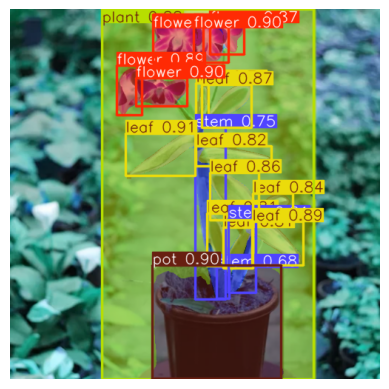

In [28]:
from ultralytics import YOLO
from PIL import Image
import requests
import matplotlib.pyplot as plt

# Load an image
image_url = "https://5.imimg.com/data5/SELLER/Default/2024/6/426884907/CX/RS/IW/46470149/dendrobium-orchid-flower-plant-500x500.png"
image = Image.open(requests.get(image_url, stream=True).raw)

# Perform segmentation
results = orchid_model.predict(image, task='segment', imgsz=640)  # Predict masks

# Extract the first result (if working with a single image)
result = results[0]

# Display the image with segmentation results
annotated_image = result.plot()  # `plot()` overlays the masks, bounding boxes, and labels onto the image

# Use matplotlib to show the annotated image
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [29]:
import cv2

# Assuming `annotated_image` is your NumPy array representing the image
annotated_image_path = '/content/output/annotated_orchid_image.png'

# Use cv2.imwrite() to save the image
cv2.imwrite(annotated_image_path, annotated_image)

print(f"Annotated image saved to: {annotated_image_path}")

Annotated image saved to: /content/output/annotated_orchid_image.png



0: 640x640 3 flowers, 6 leafs, 1 plant, 1 pot, 4 stems, 68.0ms
Speed: 3.8ms preprocess, 68.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)


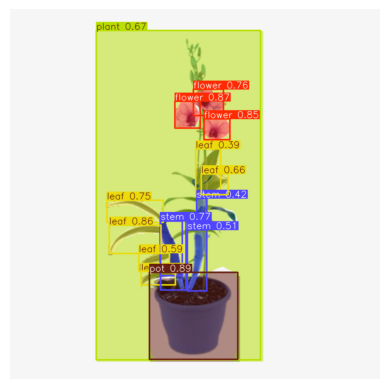

In [32]:
from ultralytics import YOLO
from PIL import Image
import requests
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/SLIIT/Y4S1/Research/test/test.jpg'
image = Image.open(image_path)

# Perform segmentation
results = orchid_model.predict(image, task='segment', imgsz=640)  # Predict masks

# Extract the first result (if working with a single image)
result = results[0]

# Display the image with segmentation results
annotated_image = result.plot()  # `plot()` overlays the masks, bounding boxes, and labels onto the image

# Use matplotlib to show the annotated image
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()


0: 640x512 20 flowers, 28 leafs, 360.9ms
Speed: 7.3ms preprocess, 360.9ms inference, 39.2ms postprocess per image at shape (1, 3, 640, 512)


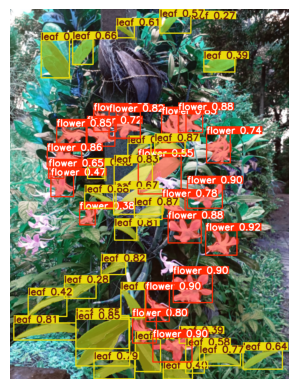

In [34]:
from ultralytics import YOLO
from PIL import Image
import requests
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/SLIIT/Y4S1/Research/test/t2.jpg'
image = Image.open(image_path)

# Perform segmentation
results = orchid_model.predict(image, task='segment', imgsz=640)  # Predict masks

# Extract the first result (if working with a single image)
result = results[0]

# Display the image with segmentation results
annotated_image = result.plot()  # `plot()` overlays the masks, bounding boxes, and labels onto the image

# Use matplotlib to show the annotated image
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()


0: 512x640 14 flowers, 26 leafs, 1 root, 3 stems, 103.1ms
Speed: 3.2ms preprocess, 103.1ms inference, 14.6ms postprocess per image at shape (1, 3, 512, 640)


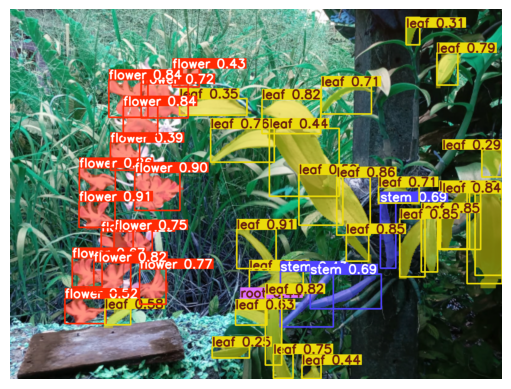

In [35]:
from ultralytics import YOLO
from PIL import Image
import requests
import matplotlib.pyplot as plt

# Load an image
image_path = '/content/drive/MyDrive/SLIIT/Y4S1/Research/test/t3.jpg'
image = Image.open(image_path)

# Perform segmentation
results = orchid_model.predict(image, task='segment', imgsz=640)  # Predict masks

# Extract the first result (if working with a single image)
result = results[0]

# Display the image with segmentation results
annotated_image = result.plot()  # `plot()` overlays the masks, bounding boxes, and labels onto the image

# Use matplotlib to show the annotated image
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [33]:
from google.colab import files

# Download the model to your local machine
files.download(output_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Deploy Model to Roboflow

In [40]:
import roboflow

# Initialize Roboflow with your API key
rf = roboflow.Roboflow(api_key="xt1xKtAXVG6mSVmmocMF")

# Get a list of projects in your default workspace
projects = rf.workspace().project('orchid1-twcxw')
print(projects)


loading Roboflow workspace...
loading Roboflow project...
{
  "name": "orchid1",
  "type": "instance-segmentation",
  "workspace": "mproject-q94fe"
}


In [41]:

# Specify the version ID of the model you want to deploy
version = project.version(7)
# Define the path to your training results directory and the model type
model_type = "yolov11"
model_weights_path = "/content/runs/segment/train2/weights/best.pt"  # Path to your model's weights file

# Deploy the model
version.deploy("yolov11", "/content/runs/segment/train2/weights", "best.pt")


# Alternatively, if you're using a torchscript model
version.deploy(model_type, "/content/output", "orchid_yolo_model.torchscript")


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/segment/train2/weights/best.pt'

In [ ]:
version.deploy("yolov8", "/content/runs/segment/train3/weights", "best.pt")


Dependency ultralytics==8.0.196 is required but found version=8.3.37, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
An error occured when getting the model upload URL: 404 Client Error: Not Found for url: https://api.roboflow.com/mproject-q94fe/orchid1-twcxw/1/uploadModel?api_key=xt1xKtAXVG6mSVmmocMF&modelType=yolov8&nocache=true
